In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from astropy.io import fits
import ccdproc as ccdp
from astropy.nddata import CCDData
from astropy.stats import mad_std
import glob
import os
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.utils import calc_total_error
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian2DKernel, convolve
import scipy.interpolate as interp

<class 'numpy.ndarray'>
(2524, 2952)
Mean: 955.3374877597826
Stdev: 8.10106289754427


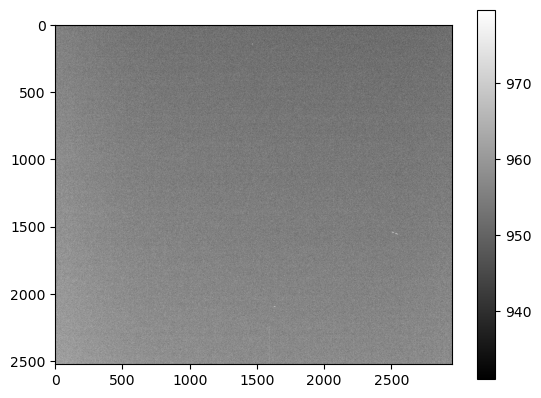

In [2]:
# Question 1
ImageFile = ("./data/bias/20171101.bias.00000274.fits")
ImageData = fits.getdata(ImageFile)
print(type(ImageData))
print(ImageData.shape)
plt.imshow(ImageData, cmap="gray",vmin=np.mean(ImageData)-3*np.std(ImageData), vmax=np.mean(ImageData)+3*np.std(ImageData))
plt.colorbar()
print("Mean:", np.mean(ImageData))
print("Stdev:", np.std(ImageData))

Mean: 957.4166866643905
Stdev: 4.399549083287437


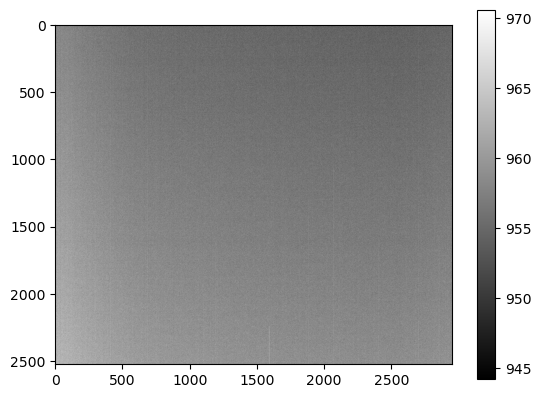

In [3]:
#Question 3
BiasFiles = glob.glob("./data/bias/*.fits")
BiasDataList = [fits.getdata(file) for file in BiasFiles]
BiasStack = np.stack(BiasDataList, axis=0)
MasterBias = np.median(BiasStack, axis=0)
hdu = fits.PrimaryHDU(MasterBias)
hdu.writeto("MasterBias.fits",overwrite=True)
MasterBiasFits = ('./MasterBias.fits')
CombinedBiasImageData = fits.getdata(MasterBiasFits)

plt.imshow(CombinedBiasImageData, cmap="gray", vmin=np.mean(CombinedBiasImageData)-3*np.std(CombinedBiasImageData), vmax=np.mean(CombinedBiasImageData)+3*np.std(CombinedBiasImageData))
plt.colorbar()
print("Mean:", np.mean(CombinedBiasImageData))
print("Stdev:", np.std(CombinedBiasImageData))

Mean: 19.0921552821907
Stdev: 126.59930217711634
-5.159660863906264 150.0


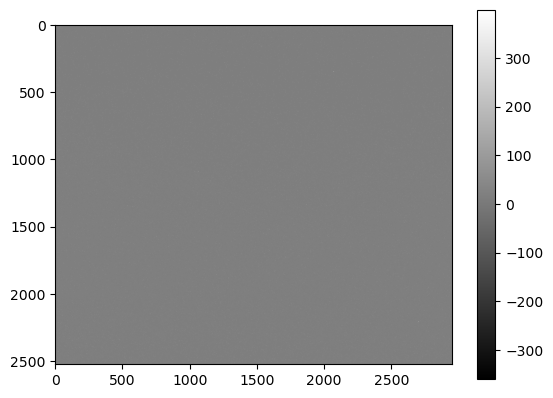

In [4]:
#Question 7
DarkFiles = glob.glob("./data/dark/*.fits")
DarkDataList = [(fits.getdata(file) - CombinedBiasImageData) for file in DarkFiles]
DarkStack = np.stack(DarkDataList, axis=0)
MasterDark = np.median(DarkStack, axis=0)
hdu = fits.PrimaryHDU(MasterDark)
hdu.writeto("MasterDark.fits",overwrite=True)
MasterDarkFits = ('./MasterDark.fits')
CombinedDarkImageData = fits.getdata(MasterDarkFits)
plt.imshow(CombinedDarkImageData, cmap="gray", vmin=np.mean(CombinedDarkImageData)-3*np.std(CombinedDarkImageData), vmax=np.mean(CombinedDarkImageData)+3*np.std(CombinedDarkImageData))
plt.colorbar()

print("Mean:", np.mean(CombinedDarkImageData))
print("Stdev:", np.std(CombinedDarkImageData))

#Question 9
TempList=[]
ExpTimeList=[]
for file in DarkFiles:
    with fits.open(file) as hdul:
        header = hdul[0].header
    TempList.append(header.get('CCD-TEMP'))
    ExpTimeList.append(header.get('EXPTIME'))
#print(header)
print(np.mean(TempList),np.mean(ExpTimeList))

Mean: 1.0289238910206993
Stdev: 0.02220258479862904
-5.17001792254751 2.8


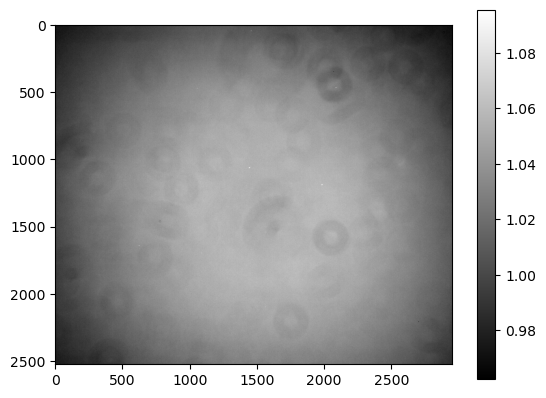

In [5]:
#Question 11
FlatFiles = glob.glob("./data/flat_R/*.fits")
FlatDataList = [(fits.getdata(file) - CombinedBiasImageData - CombinedDarkImageData) for file in FlatFiles]
for all in FlatDataList:
    FlatDataList=FlatDataList/np.mean(FlatDataList)
FlatStack = np.stack(FlatDataList, axis=0)
MasterFlat = np.median(FlatStack, axis=0)
hdu = fits.PrimaryHDU(MasterFlat)
hdu.writeto("MasterFlat.fits",overwrite=True)
MasterFlatFits = ('./MasterFlat.fits')
CombinedFlatImageData = fits.getdata(MasterFlatFits)
plt.imshow(CombinedFlatImageData, cmap="gray", vmin=np.mean(CombinedFlatImageData)-3*np.std(CombinedFlatImageData), vmax=np.mean(CombinedFlatImageData)+3*np.std(CombinedFlatImageData))
plt.colorbar()

print("Mean:", np.mean(CombinedFlatImageData))
print("Stdev:", np.std(CombinedFlatImageData))
TempList=[]
ExpTimeList=[]
for file in FlatFiles:
    with fits.open(file) as hdul:
        header = hdul[0].header
    TempList.append(header.get('CCD-TEMP'))
    ExpTimeList.append(header.get('EXPTIME'))
print(np.mean(TempList),np.mean(ExpTimeList))

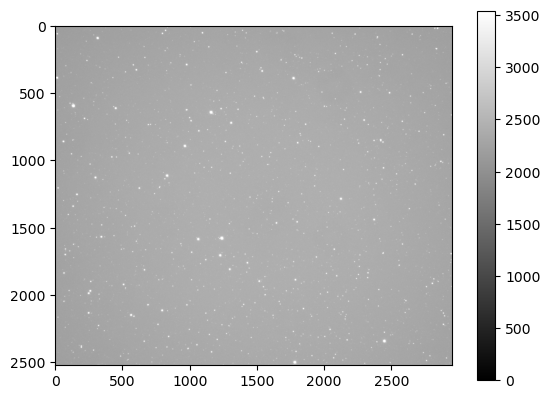

In [6]:
# Question 18

ScienceFiles = glob.glob("./data/science_R/*.fits")
ScienceDataList = [(fits.getdata(file) - CombinedBiasImageData - CombinedDarkImageData*0.5) for file in ScienceFiles]
#ExpTimeList=[]
for file in ScienceFiles:
    with fits.open(file) as hdul:
        header = hdul[0].header
#    ExpTimeList.append(header.get('EXPTIME'))
#print(ExpTimeList)            == [0.5,0.5,0.5]

#print(ScienceDataList[0])
ScienceDataList=np.array(ScienceDataList)*2
ScienceStack = np.stack(ScienceDataList, axis=0)
#print(ScienceDataList[0])

hdu1 = fits.PrimaryHDU(ScienceStack[0])
hdu1.writeto("135.fits",overwrite=True)
hdu2 = fits.PrimaryHDU(ScienceStack[1])
hdu2.writeto("136.fits",overwrite=True)
hdu3 = fits.PrimaryHDU(ScienceStack[2])
hdu3.writeto("137.fits",overwrite=True)

OneThreeFiveFits = ('./135.fits')
OneThreeFiveImageData = fits.getdata(OneThreeFiveFits)
plt.imshow(OneThreeFiveImageData, cmap="gray", vmin=0, vmax=np.mean(OneThreeFiveImageData)+2*np.std(OneThreeFiveImageData))
plt.colorbar()
plt.savefig("135.pdf")


2356.0 62.3392037957025


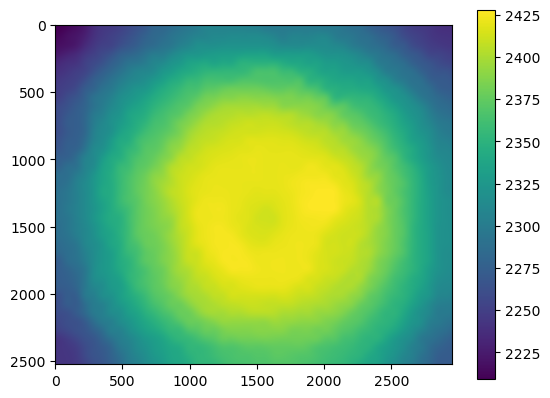

In [7]:
with fits.open('135.fits') as hdul:
    data = hdul[0].data.astype(float)
#    header = fits.getheader("135.fits")
Background = Background2D(data,64,filter_size=5,bkg_estimator=MedianBackground())
#print(header)
print(Background.background_median,Background.background_rms_median)

hdu = fits.PrimaryHDU(Background.background)
hdu.writeto("Background.fits",overwrite=True)
BackgroundData = fits.getdata('./Background.fits')

plt.imshow(BackgroundData)
plt.colorbar()
plt.savefig("2DBackground.pdf")


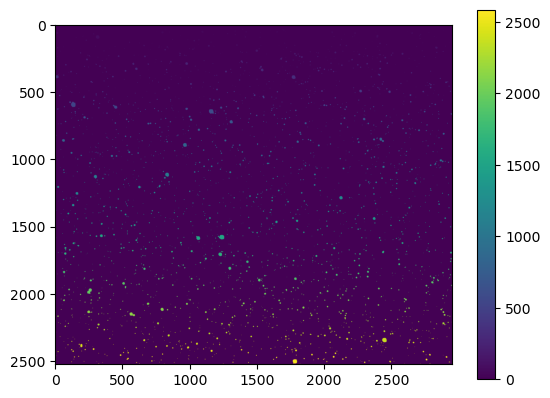

In [8]:
# Question 24
Background = Background2D(data,64,filter_size=5,bkg_estimator=MedianBackground())
Threshold = Background.background + (2 * Background.background_rms)

Kernel=Gaussian2DKernel(3/2.355,x_size=9,y_size=9)
Kernel.normalize()

Segmentation = detect_sources(convolve(data, Kernel), threshold=Threshold, npixels=5)
SegmentationDeBlend = deblend_sources(convolve(data, Kernel), Segmentation, npixels=5, nlevels=32, contrast=0.001)
plt.imshow(Segmentation.data)
plt.colorbar()
plt.savefig("Segmentation.pdf")

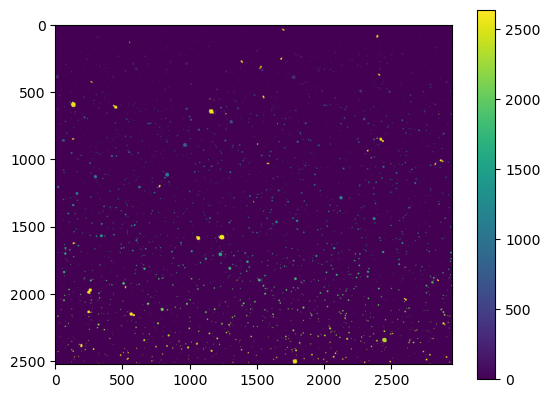

In [9]:
plt.imshow(SegmentationDeBlend.data)
plt.colorbar()
plt.savefig("SegmentationDeBlend.pdf")

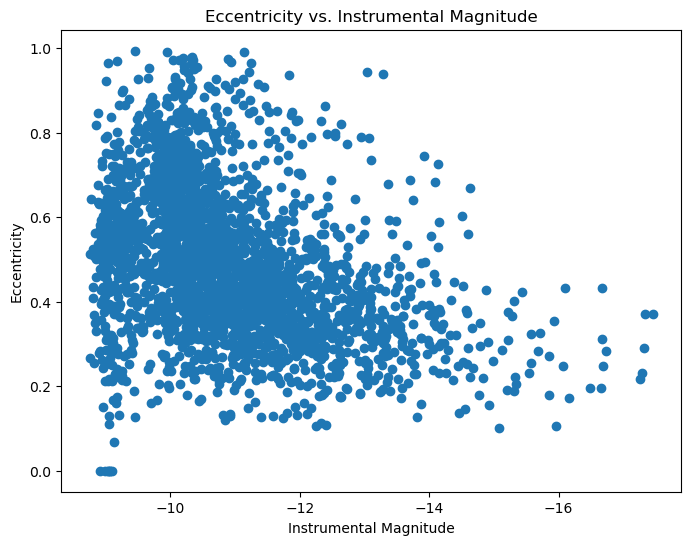

<Figure size 640x480 with 0 Axes>

In [10]:
# Question 26
SubtractedBackground = data - Background.background
BackgroundRMS = Background.background_rms
Catalog = SourceCatalog(SubtractedBackground, SegmentationDeBlend, error=calc_total_error(SubtractedBackground,BackgroundRMS,effective_gain=1.4), background=Background.background)
Table = Catalog.to_table()
Table['instrumental_magnitude'] = -2.5 * np.log10(Table['kron_flux'] / 0.5)

plt.figure(figsize=(8,6))
plt.scatter(Table['instrumental_magnitude'], Table['eccentricity'])
plt.gca().invert_xaxis()
plt.xlabel('Instrumental Magnitude')
plt.ylabel('Eccentricity')
plt.title('Eccentricity vs. Instrumental Magnitude')
plt.show()
plt.savefig("Eccentricity vs. Instrumental Magnitude.pdf")

In [11]:
i=0
while i < len(Table['xcentroid']):
    if Table['xcentroid'][i] <= 557 and Table['xcentroid'][i] >= 551:
        print(Table['xcentroid'][i])
    if Table['ycentroid'][i] <= 518 and Table['ycentroid'][i] >= 512:
        print(Table['ycentroid'][i])
    i=i+1


512.9789528652339
513.3206385380067
513.0875527295628
515.0325422776185
514.9811087702582
515.905933070092
516.0316585746115
551.9610193041531
554.3852998165889
553.4933425049202
555.8864692767709


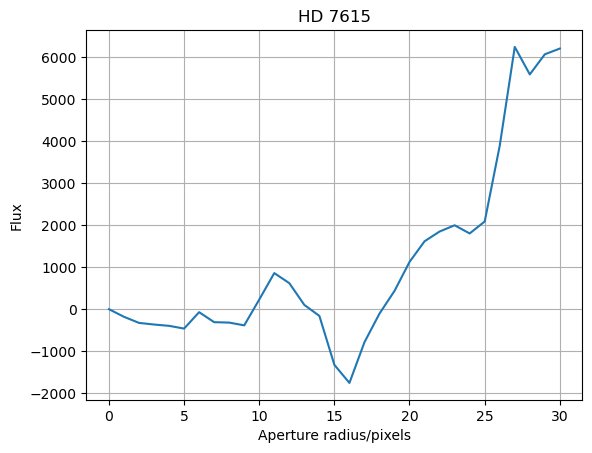

In [12]:
Position = [(552.5126724625848,515.8907949722843)]
Radii = np.arange(0.01, 30.1, 1)
Fluxes = []
for r in Radii:
    Aperture = CircularAperture(Position, r)
    PhotTable = aperture_photometry(SubtractedBackground, Aperture)
    Flux = PhotTable['aperture_sum'][0]
    Fluxes.append(Flux)
plt.plot(Radii, Fluxes)
plt.xlabel('Aperture radius/pixels')
plt.ylabel('Flux')
plt.title('HD 7615')
plt.grid()
plt.show()


In [13]:
print(-2.5 * np.log10(aperture_photometry(SubtractedBackground, CircularAperture(Position, 10))['aperture_sum'][0] / 0.5))

-6.609121924875398


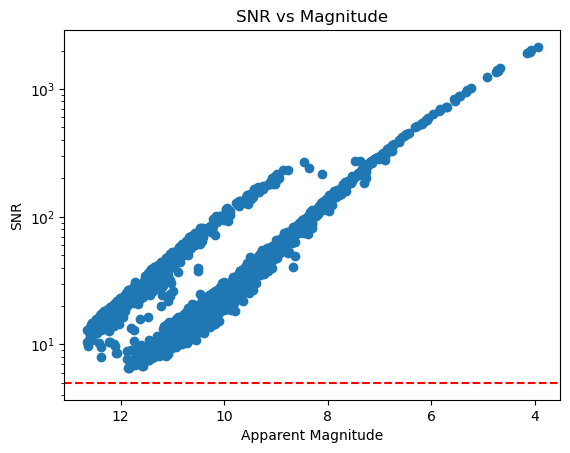

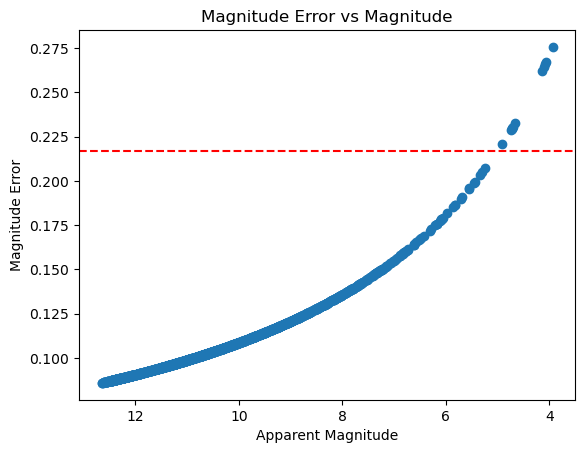

In [14]:
Table['apparent_magnitude']=Table['instrumental_magnitude']+21.401
Table['signal_to_noise']=Table['kron_flux']/Table['kron_fluxerr']

plt.scatter(Table['apparent_magnitude'], Table['signal_to_noise'])
plt.axhline(5, color='r', linestyle='--')
plt.xlabel('Apparent Magnitude')
plt.ylabel('SNR')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.title('SNR vs Magnitude')
plt.show()

plt.scatter(Table['apparent_magnitude'], 1.0857 * Table['apparent_magnitude']**-1)
plt.axhline(0.217, color='r', linestyle='--')
plt.xlabel('Apparent Magnitude')
plt.ylabel('Magnitude Error')
plt.gca().invert_xaxis()
plt.title('Magnitude Error vs Magnitude')
plt.show()


In [15]:
SortIDX = np.argsort(Table['apparent_magnitude'])
mSorted = Table['apparent_magnitude'][SortIDX]
SNRSorted = Table['signal_to_noise'][SortIDX]
Interpolated = interp.interp1d(np.log10(SNRSorted), mSorted, fill_value='extrapolate')
MagLimit = float(Interpolated(np.log10(5)))
print(MagLimit)


5.459829879107755
